# Lab 4c. Deep Learning - iNaturalist
### Desik Somasundaram

## Import packages

In [25]:
import keras
import os, shutil
import pandas
from random import sample
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
keras.__version__

'2.6.0'

## Explore data

In [2]:
# Examine original iNat data
os. getcwd() 
dir_train_mini = "./data/train_mini"
dirs_spp = os.listdir(dir_train_mini)
n_spp = len(dirs_spp) # 10,000 species directories
n_spp 

10000

In [3]:
# Sample 10 species randomly
i10 = sample(range(1,n_spp),10)
i10

[8726, 9619, 5231, 9983, 739, 5422, 6616, 6373, 7368, 6957]

In [4]:
# show/select the first 2 species directory names from random 10
i2 = i10[0:2]

## Copy over, Read in and Prep data

In [5]:
# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/Users/desik/github/lab4-ml-deeplearning/data/train_mini'

# The directory where we will
# store our smaller dataset
base_dir = '/Users/desik/github/lab4-ml-deeplearning/data/train_mini_subset'
# this line clear the base dir, comment out if you don't want to start over
shutil.rmtree(base_dir)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

In [6]:
# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

In [7]:
# Select 2 species for first two parts of lab
speciesfolders = []
for i in i2:
    speciesfolders.append(os.path.basename(dirs_spp[i]))
speciesfolders

['01269_Animalia_Arthropoda_Insecta_Lepidoptera_Geometridae_Nemoria_bistriaria',
 '05106_Animalia_Chordata_Reptilia_Squamata_Viperidae_Agkistrodon_conanti']

In [8]:
# Create directories for each species in train, validation and test subfolders
# Get filenames for each species in original dataset
train_species_folders = []
validation_species_folders = []
test_species_folders = []
speciesfnames = []

# selected train, validation and test data sizes
n_train = 30
n_validation = 10
n_test = 10

# iterates through the two species selected in i2
i = 0
while i < len(i2):
    train_species_dir = os.path.join(train_dir, speciesfolders[i])
    train_species_folders.append(train_species_dir)
    if not os.path.exists(train_species_dir):
        os.mkdir(train_species_dir)
    validation_species_dir = os.path.join(validation_dir, speciesfolders[i])
    validation_species_folders.append(validation_species_dir)
    if not os.path.exists(validation_species_dir):
        os.mkdir(validation_species_dir)
    test_species_dir = os.path.join(test_dir, speciesfolders[i])
    test_species_folders.append(test_species_dir)
    if not os.path.exists(test_species_dir):
        os.mkdir(test_species_dir)
    n = 0
    for files in os.walk(os.path.join(original_dataset_dir, speciesfolders[i]), topdown=False):
       for name in files:
            n = n + 1
            if n > 2:
                speciesfnames.append(name)
    i = i + 1

In [9]:
# Copy over original data and split into train, validation and test based on specified sizes
i = 0
while i < len(i2):
    n = 0
    for fname in speciesfnames[i]:
        src = os.path.join(original_dataset_dir, speciesfolders[i], fname)
        if n < n_train:
            dst = os.path.join(train_species_folders[i], fname)
            n = n + 1
        elif n < n_train + n_validation:
            dst = os.path.join(validation_species_folders[i], fname)
            n = n + 1
        elif n < (n_train + n_validation + n_test):
            dst = os.path.join(test_species_folders[i], fname)
            n = n + 1
        shutil.copyfile(src, dst)
    i = i + 1

In [10]:
# sanity check on sizes of data splits
print('total training species 1 images:', len(os.listdir(train_species_folders[0])))

total training species 1 images: 30


In [11]:
# sanity check on sizes of data splits
print('total test species 2 images:', len(os.listdir(test_species_folders[1])))

total test species 2 images: 10


In [12]:
# sanity check on sizes of data splits
print('total validation species 2 images:', len(os.listdir(validation_species_folders[1])))

total validation species 2 images: 10


In [13]:
# sanity check on sizes of data splits
print('total test species 1 images:', len(os.listdir(test_species_folders[0])))

total test species 1 images: 10


## 2 Species (binary classification) - neural net

In [14]:
# image preprocessing for model with binary classificaiotn
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='binary')

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [15]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (4, 150, 150, 3)
labels batch shape: (4,)


### Neural net model

In [16]:
# Build neural net model
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(150, 150, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


2022-02-22 03:28:26.355055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.5/lib/R/lib::/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-02-22 03:28:26.355109: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-22 03:28:26.355129: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (taylor): /proc/driver/nvidia/version does not exist
2022-02-22 03:28:26.355398: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [17]:
# default optimizer and loss/metrics
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# custom optimizer

#model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#              loss='binary_crossentropy',
#             metrics=['accuracy'])

# custom optimizer and custom loss/metrics

#model.compile(optimizer=optimizers.RMSprop(lr=0.001),
#             loss=losses.binary_crossentropy,
#             metrics=[metrics.binary_accuracy])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150, 150, 16)      64        
_________________________________________________________________
flatten (Flatten)            (None, 360000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                5760016   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 5,760,097
Trainable params: 5,760,097
Non-trainable params: 0
_________________________________________________________________


In [19]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40


2022-02-22 03:28:26.496345: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


5/5 [==============================] - 1s 97ms/step - loss: 9.8621 - accuracy: 0.6000 - val_loss: 14.7485 - val_accuracy: 0.5000
Epoch 2/40
5/5 [==============================] - 0s 64ms/step - loss: 11.3887 - accuracy: 0.5000 - val_loss: 6.3113 - val_accuracy: 0.5000
Epoch 3/40
5/5 [==============================] - 0s 60ms/step - loss: 11.8075 - accuracy: 0.5000 - val_loss: 5.4249 - val_accuracy: 0.5000
Epoch 4/40
5/5 [==============================] - 0s 73ms/step - loss: 8.6162 - accuracy: 0.4000 - val_loss: 4.1105 - val_accuracy: 0.5000
Epoch 5/40
5/5 [==============================] - 0s 63ms/step - loss: 1.5447 - accuracy: 0.7000 - val_loss: 6.4331 - val_accuracy: 0.5000
Epoch 6/40
5/5 [==============================] - 0s 62ms/step - loss: 12.9976 - accuracy: 0.3000 - val_loss: 10.7166 - val_accuracy: 0.5000
Epoch 7/40
5/5 [==============================] - 0s 68ms/step - loss: 1.8850 - accuracy: 0.8500 - val_loss: 2.4625 - val_accuracy: 0.5500
Epoch 8/40
5/5 [=================

In [20]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
model.save('2Species-binaryclassification-neuralnet.h5')

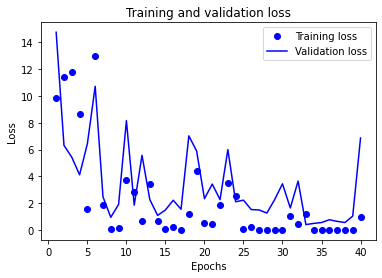

In [23]:
# neural net: accuracy metric and validation in the fitting process and history plot
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 2 Species (binary classification) - convolutional neural net

In [27]:
# Build convolutional neural net model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [29]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 2s 273ms/step - loss: 0.6789 - acc: 0.6500 - val_loss: 0.6910 - val_acc: 0.5000
Epoch 2/40
5/5 [==============================] - 1s 128ms/step - loss: 0.7154 - acc: 0.5500 - val_loss: 0.7036 - val_acc: 0.5000
Epoch 3/40
5/5 [==============================] - 1s 206ms/step - loss: 0.7100 - acc: 0.3500 - val_loss: 0.7139 - val_acc: 0.5000
Epoch 4/40
5/5 [==============================] - 1s 134ms/step - loss: 0.6948 - acc: 0.6500 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 5/40
5/5 [==============================] - 1s 157ms/step - loss: 0.6691 - acc: 0.6500 - val_loss: 0.6928 - val_acc: 0.5000
Epoch 6/40
5/5 [==============================] - 1s 108ms/step - loss: 0.6619 - acc: 0.6500 - val_loss: 0.6862 - val_acc: 0.5000
Epoch 7/40
5/5 [==============================] - 1s 154ms/step - loss: 0.6198 - acc: 0.6500 - val_loss: 0.6617 - val_acc: 0.5000
Epoch 8/40
5/5 [==============================] - 1s 132ms/step - loss: 0.6972 - acc: 0.55

In [30]:
model.save('2Species-binaryclassification-convnet.h5')

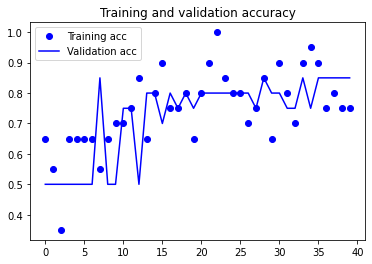

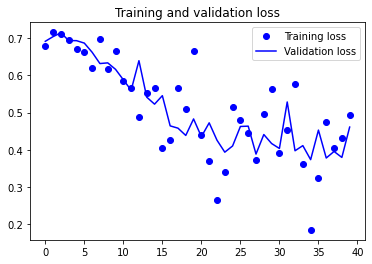

In [31]:
# conv net: accuracy metric and validation in the fitting process and history plot
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Write up comparing results

# 10 Species (multi-class classification) - neural net

In [32]:
# Select 10 species for second two parts of lab
speciesfolders = []
for i in i10:
    speciesfolders.append(os.path.basename(dirs_spp[i]))
speciesfolders

['01269_Animalia_Arthropoda_Insecta_Lepidoptera_Geometridae_Nemoria_bistriaria',
 '05106_Animalia_Chordata_Reptilia_Squamata_Viperidae_Agkistrodon_conanti',
 '03228_Animalia_Chordata_Aves_Anseriformes_Anatidae_Branta_leucopsis',
 '00582_Animalia_Arthropoda_Insecta_Hemiptera_Gerridae_Aquarius_remigis',
 '04660_Animalia_Chordata_Mammalia_Artiodactyla_Delphinidae_Tursiops_truncatus',
 '05791_Plantae_Tracheophyta_Liliopsida_Alismatales_Araceae_Alocasia_odora',
 '04959_Animalia_Chordata_Reptilia_Squamata_Colubridae_Salvadora_hexalepis',
 '08369_Plantae_Tracheophyta_Magnoliopsida_Geraniales_Geraniaceae_Erodium_texanum',
 '09545_Plantae_Tracheophyta_Magnoliopsida_Sapindales_Anacardiaceae_Searsia_lucida',
 '08211_Plantae_Tracheophyta_Magnoliopsida_Fagales_Juglandaceae_Carya_glabra']

In [33]:
# Create directories for each species in train, validation and test subfolders
# Get filenames for each species in original dataset
train_species_folders = []
validation_species_folders = []
test_species_folders = []
speciesfnames = []

# selected train, validation and test data sizes
n_train = 30
n_validation = 10
n_test = 10

# iterates through the ten species selected in i10
i = 0
while i < len(i10):
    train_species_dir = os.path.join(train_dir, speciesfolders[i])
    train_species_folders.append(train_species_dir)
    if not os.path.exists(train_species_dir):
        os.mkdir(train_species_dir)
    validation_species_dir = os.path.join(validation_dir, speciesfolders[i])
    validation_species_folders.append(validation_species_dir)
    if not os.path.exists(validation_species_dir):
        os.mkdir(validation_species_dir)
    test_species_dir = os.path.join(test_dir, speciesfolders[i])
    test_species_folders.append(test_species_dir)
    if not os.path.exists(test_species_dir):
        os.mkdir(test_species_dir)
    n = 0
    for files in os.walk(os.path.join(original_dataset_dir, speciesfolders[i]), topdown=False):
       for name in files:
            n = n + 1
            if n > 2:
                speciesfnames.append(name)
    i = i + 1

In [34]:
# Copy over original data and split into train, validation and test based on specified sizes
i = 0
while i < len(i10):
    n = 0
    for fname in speciesfnames[i]:
        src = os.path.join(original_dataset_dir, speciesfolders[i], fname)
        if n < n_train:
            dst = os.path.join(train_species_folders[i], fname)
            n = n + 1
        elif n < n_train + n_validation:
            dst = os.path.join(validation_species_folders[i], fname)
            n = n + 1
        elif n < (n_train + n_validation + n_test):
            dst = os.path.join(test_species_folders[i], fname)
            n = n + 1
        shutil.copyfile(src, dst)
    i = i + 1

In [35]:
# sanity check on sizes of data splits
print('total training species 1 images:', len(os.listdir(train_species_folders[0])))

total training species 1 images: 30


In [36]:
# sanity check on sizes of data splits
print('total test species 3 images:', len(os.listdir(test_species_folders[2])))

total test species 3 images: 10


In [37]:
# sanity check on sizes of data splits
print('total validation species 9 images:', len(os.listdir(validation_species_folders[8])))

total validation species 9 images: 10


In [38]:
# image preprocessing for model with multi classificaiotn
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=5,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=5,
        class_mode='categorical')

Found 300 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [39]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (5, 150, 150, 3)
labels batch shape: (5, 10)


### Neural net model

In [40]:
# Build neural net model
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(150,150,3)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [41]:
# default optimizer and loss/metrics
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 150, 150, 64)      256       
_________________________________________________________________
flatten_4 (Flatten)          (None, 1440000)           0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                92160064  
_________________________________________________________________
dense_11 (Dense)             (None, 10)                650       
Total params: 92,160,970
Trainable params: 92,160,970
Non-trainable params: 0
_________________________________________________________________


In [43]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 2s 337ms/step - loss: 255.8026 - accuracy: 0.0400 - val_loss: 88.4530 - val_accuracy: 0.0800
Epoch 2/40
5/5 [==============================] - 2s 326ms/step - loss: 31.0436 - accuracy: 0.1200 - val_loss: 52.2330 - val_accuracy: 0.1600
Epoch 3/40
5/5 [==============================] - 2s 343ms/step - loss: 17.0740 - accuracy: 0.0400 - val_loss: 2.3510 - val_accuracy: 0.0800
Epoch 4/40
5/5 [==============================] - 2s 324ms/step - loss: 14.9057 - accuracy: 0.0800 - val_loss: 2.2853 - val_accuracy: 0.2400
Epoch 5/40
5/5 [==============================] - 2s 333ms/step - loss: 14.6294 - accuracy: 0.1200 - val_loss: 4.3574 - val_accuracy: 0.1200
Epoch 6/40
5/5 [==============================] - 2s 326ms/step - loss: 2.5255 - accuracy: 0.1200 - val_loss: 2.4218 - val_accuracy: 0.2000
Epoch 7/40
5/5 [==============================] - 2s 330ms/step - loss: 10.6020 - accuracy: 0.0400 - val_loss: 2.3042 - val_accuracy: 0.0800
Epoch 8/40


In [44]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
model.save('10Species-multiclassification-neuralnet.h5')

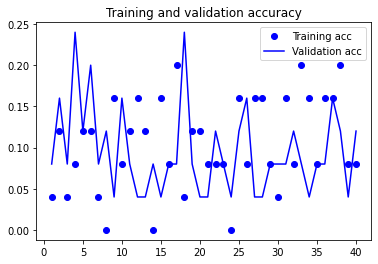

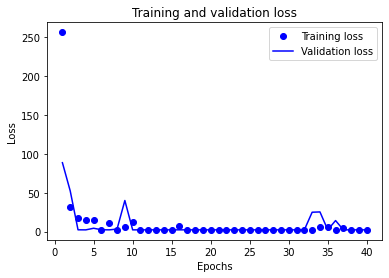

In [46]:
# neural net: accuracy metric and validation in the fitting process and history plot
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 10 Species (multi classification) - convolutional neural net

In [47]:
# Build convolutional neural net model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)      

In [49]:
# model fit
history = model.fit(
      train_generator,
      steps_per_epoch=5,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=5)

Epoch 1/40
5/5 [==============================] - 1s 144ms/step - loss: 4.0064 - accuracy: 0.0800 - val_loss: 2.3378 - val_accuracy: 0.1200
Epoch 2/40
5/5 [==============================] - 1s 104ms/step - loss: 2.3482 - accuracy: 0.0400 - val_loss: 2.2906 - val_accuracy: 0.1600
Epoch 3/40
5/5 [==============================] - 1s 108ms/step - loss: 2.2987 - accuracy: 0.1200 - val_loss: 2.3049 - val_accuracy: 0.1600
Epoch 4/40
5/5 [==============================] - 1s 111ms/step - loss: 2.3015 - accuracy: 0.1200 - val_loss: 2.3004 - val_accuracy: 0.0400
Epoch 5/40
5/5 [==============================] - 1s 113ms/step - loss: 2.3170 - accuracy: 0.0400 - val_loss: 2.2850 - val_accuracy: 0.1600
Epoch 6/40
5/5 [==============================] - 1s 110ms/step - loss: 2.3354 - accuracy: 0.0800 - val_loss: 2.3037 - val_accuracy: 0.0400
Epoch 7/40
5/5 [==============================] - 0s 101ms/step - loss: 2.3357 - accuracy: 0.2000 - val_loss: 2.2997 - val_accuracy: 0.1200
Epoch 8/40
5/5 [====

In [50]:
model.save('10Species-multiclassification-convnet.h5')

In [51]:
# find keys for history dictionary
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

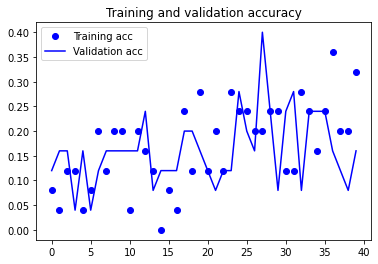

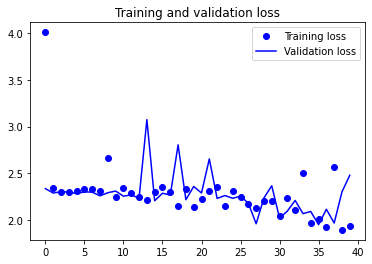

In [52]:
# conv net: accuracy metric and validation in the fitting process and history plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Write up comparing results